<a href="https://colab.research.google.com/github/Harishankarvel/LAUN_ML_project/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

Dataset 'ODI.csv' loaded successfully from the Colab session.
Starting advanced feature engineering... (This might take a moment)
Feature engineering complete.

Starting hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best model parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

--- Final Tuned Model Evaluation ---
Final Accuracy: 56.47%

Classification Report:
              precision    recall  f1-score   support

        Loss       0.54      0.60      0.56       121
         Win       0.60      0.54      0.56       134

    accuracy                           0.56       255
   macro avg       0.57      0.57      0.56       255
weighted avg       0.57      0.56      0.56       255


Generating graphical representations...


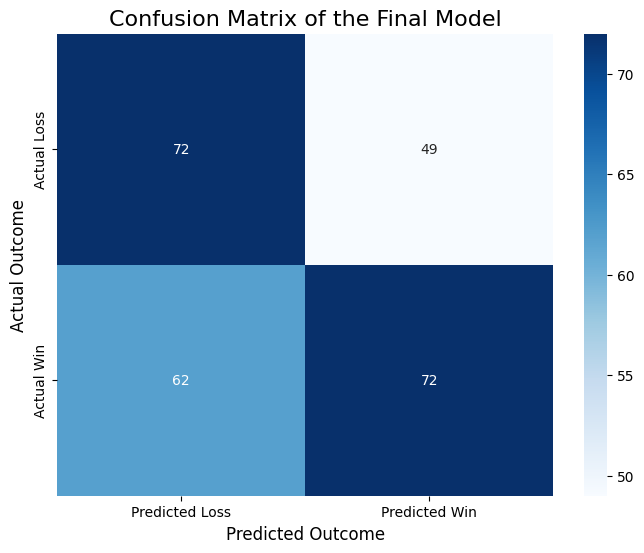

/tmp/ipython-input-3404196336.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


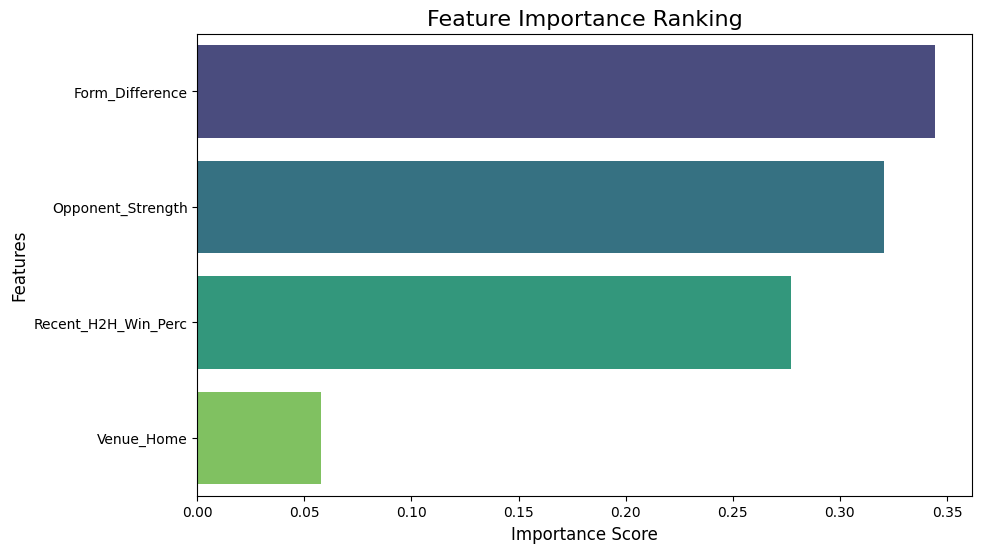

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading and Initial Cleaning ---
try:
    df_raw = pd.read_csv('ODI.csv')
    print("Dataset 'ODI.csv' loaded successfully from the Colab session.")
except FileNotFoundError:
    print("ERROR: 'ODI.csv' not found. Please upload the file to your Colab session.")
    exit()

df_raw.rename(columns={'Team_1': 'Team 1', 'Team_2': 'Team 2'}, inplace=True)
df_raw['Date'] = pd.to_datetime(df_raw['Match Date'], errors='coerce')
df_raw.dropna(subset=['Date', 'Winner', 'Team 1', 'Team 2', 'Ground'], inplace=True)
df_raw = df_raw.sort_values('Date').reset_index(drop=True)

# --- 2. Advanced Feature Engineering ---

# Create a helper function to get team form to avoid repetitive code
def get_team_form(df, team_name, date):
    team_matches = df[((df['Team 1'] == team_name) | (df['Team 2'] == team_name)) & (df['Date'] < date)]
    if len(team_matches) == 0:
        return 50.0 # Return a neutral 50% if no prior matches exist

    last_10_matches = team_matches.tail(10)
    wins = (last_10_matches['Winner'] == team_name).sum()
    return (wins / len(last_10_matches)) * 100

# Isolate India matches and prepare basic features
df_india = df_raw[(df_raw['Team 1'] == 'India') | (df_raw['Team 2'] == 'India')].copy()
df_india['India_Won'] = (df_india['Winner'] == 'India').astype(int)
df_india['Opponent'] = df_india.apply(lambda row: row['Team 2'] if row['Team 1'] == 'India' else row['Team 1'], axis=1)

print("Starting advanced feature engineering... (This might take a moment)")
# Apply the form calculation for both India and the Opponent for each match
forms = df_india.apply(lambda row: (get_team_form(df_india, 'India', row['Date']), get_team_form(df_raw, row['Opponent'], row['Date'])), axis=1)
df_india['India_Form_Last_10'] = [form[0] for form in forms]
df_india['Opponent_Form_Last_10'] = [form[1] for form in forms]

# Feature 1: Form Difference
df_india['Form_Difference'] = df_india['India_Form_Last_10'] - df_india['Opponent_Form_Last_10']

# Feature 2: Recent Head-to-Head (last 10 matches)
df_india['Recent_H2H_Wins'] = df_india.groupby('Opponent')['India_Won'].transform(lambda x: x.shift(1).rolling(10, min_periods=1).sum())
df_india['Recent_H2H_Matches'] = df_india.groupby('Opponent')['India_Won'].transform(lambda x: x.shift(1).rolling(10, min_periods=1).count())
df_india['Recent_H2H_Win_Perc'] = (df_india['Recent_H2H_Wins'] / df_india['Recent_H2H_Matches']).fillna(50)

# Feature 3: Venue
indian_cities = ['Mumbai', 'Kolkata', 'Delhi', 'Chennai', 'Bangalore', 'Hyderabad', 'Ahmedabad', 'Pune', 'Jaipur', 'Kanpur', 'Nagpur', 'Mohali', 'Indore']
df_india['Venue'] = df_india['Ground'].apply(lambda ground: 'Home' if any(city in ground for city in indian_cities) else 'Away_Neutral')

# Feature 4: Opponent Strength (All-time)
team_wins = df_raw['Winner'].value_counts()
team_matches = pd.concat([df_raw['Team 1'], df_raw['Team 2']]).value_counts()
df_india['Opponent_Strength'] = df_india['Opponent'].map((team_wins / team_matches).fillna(0) * 100)
print("Feature engineering complete.")

# --- 3. Data Preparation ---
df_model = pd.get_dummies(df_india, columns=['Venue'], drop_first=True)
features = ['Opponent_Strength', 'Form_Difference', 'Recent_H2H_Win_Perc', 'Venue_Home']
target = 'India_Won'

df_model.dropna(subset=features, inplace=True)
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# --- 4. Hyperparameter Tuning ---
print("\nStarting hyperparameter tuning...")
param_grid = {'n_estimators': [150, 200], 'max_depth': [10, 20], 'min_samples_leaf': [2, 4], 'min_samples_split': [5, 10]}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print("\nBest model parameters found:", grid_search.best_params_)

# --- 5. Final Model Evaluation ---
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Final Tuned Model Evaluation ---")
print(f"Final Accuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))

# --- 6. Graphical Representations ---
print("\nGenerating graphical representations...")
# a) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Loss', 'Predicted Win'], yticklabels=['Actual Loss', 'Actual Win'])
plt.title('Confusion Matrix of the Final Model', fontsize=16)
plt.ylabel('Actual Outcome', fontsize=12)
plt.xlabel('Predicted Outcome', fontsize=12)
plt.show()

# b) Feature Importance Plot
importance_df = pd.DataFrame({'Feature': features, 'Importance': best_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance Ranking', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

Dataset 'ODI.csv' loaded successfully.

--- Data with Engineered Features (Last 5 Matches) ---
           Date     Opponent  Opponent_Strength  India_Won
4508 2023-01-21  New Zealand          46.027743          1
4510 2023-01-24  New Zealand          46.027743          1
4537 2023-03-17    Australia          60.802469          1
4540 2023-03-19    Australia          60.802469          0
4544 2023-03-22    Australia          60.802469          0

Training data shape: (765, 1)
Testing data shape: (255, 1)

--- Model Evaluation ---
Accuracy: 58.43%

Classification Report:
              precision    recall  f1-score   support

        Loss       0.57      0.51      0.54       121
         Win       0.60      0.65      0.62       134

    accuracy                           0.58       255
   macro avg       0.58      0.58      0.58       255
weighted avg       0.58      0.58      0.58       255


Confusion Matrix:


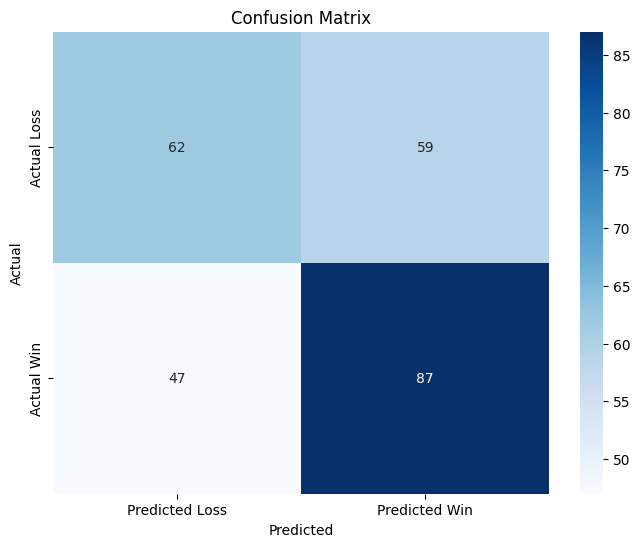


--- Hypothetical Match Prediction ---
Match: India vs. Australia
Opponent (Australia) Strength Score: 60.80
Predicted Outcome: Loss
Model's Confidence (Probability of Win): 34.01%


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Data Loading and Initial Cleaning ---
try:
    # This will now find the 'ODI.csv' file you uploaded
    df_raw = pd.read_csv('ODI.csv')
    print("Dataset 'ODI.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'ODI.csv' not found. Please ensure the file is uploaded to your Colab session.")
    exit()

# Rename columns for consistency
df_raw.rename(columns={'Team_1': 'Team 1', 'Team_2': 'Team 2'}, inplace=True)

# Convert 'Match Date' column and handle potential errors
df_raw['Date'] = pd.to_datetime(df_raw['Match Date'], errors='coerce')
df_raw.dropna(subset=['Date', 'Winner', 'Team 1', 'Team 2'], inplace=True)

# --- 2. Feature Engineering ---
# Calculate historical win percentages for all teams as a "strength" metric
all_teams = pd.unique(df_raw[['Team 1', 'Team 2']].values.ravel('K'))
team_wins = df_raw['Winner'].value_counts()
team_matches = pd.concat([df_raw['Team 1'], df_raw['Team 2']]).value_counts()
team_win_percentage = (team_wins / team_matches).fillna(0) * 100
team_strength = team_win_percentage.to_dict()

# Isolate all matches played by India
df_india = df_raw[(df_raw['Team 1'] == 'India') | (df_raw['Team 2'] == 'India')].copy()

# a) Create the target variable 'India_Won' (1 for win, 0 for loss)
df_india['India_Won'] = (df_india['Winner'] == 'India').astype(int)

# b) Create 'Opponent' feature
df_india['Opponent'] = df_india.apply(lambda row: row['Team 2'] if row['Team 1'] == 'India' else row['Team 1'], axis=1)

# c) Create 'Opponent_Strength' feature
df_india['Opponent_Strength'] = df_india['Opponent'].map(team_strength)

print("\n--- Data with Engineered Features (Last 5 Matches) ---")
print(df_india[['Date', 'Opponent', 'Opponent_Strength', 'India_Won']].tail())

# --- 3. Data Preparation for Modeling ---
# The model will only use Opponent_Strength as a feature
features = ['Opponent_Strength']
target = 'India_Won'
df_model = df_india[features + [target]].copy()
df_model.dropna(inplace=True)

X = df_model[features]
y = df_model[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- 4. Model Training and Evaluation ---
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Loss', 'Predicted Win'], yticklabels=['Actual Loss', 'Actual Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# --- 5. Prediction on a Hypothetical Future Match ---
try:
    aus_strength = team_strength['Australia']
except KeyError:
    print("\nWarning: 'Australia' not found. Using an average strength value.")
    aus_strength = np.mean(list(team_strength.values()))

hypothetical_match = pd.DataFrame({'Opponent_Strength': [aus_strength]})
predicted_outcome = model.predict(hypothetical_match)[0]
win_probability = model.predict_proba(hypothetical_match)[0][1]

print("\n--- Hypothetical Match Prediction ---")
print(f"Match: India vs. Australia")
print(f"Opponent (Australia) Strength Score: {aus_strength:.2f}")
print(f"Predicted Outcome: {'Win' if predicted_outcome == 1 else 'Loss'}")
print(f"Model's Confidence (Probability of Win): {win_probability:.2%}")